In [43]:
import jax
import jax.numpy as jnp
from jax import vmap
import numpyro
import numpyro.distributions as dist
from numpyro import sample
import multiprocessing
import os

# Set number of CPU cores JAX will use
num_cores = multiprocessing.cpu_count()-1  # Get number of available CPU cores
# Use all available cores since we want maximum performance
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={num_cores}"
print(f"Using {num_cores} cores for JAX")

# Configure thread count for better performance
os.environ["OPENBLAS_NUM_THREADS"] = str(num_cores)
os.environ["MKL_NUM_THREADS"] = str(num_cores)
os.environ["OMP_NUM_THREADS"] = str(num_cores)  # Added OpenMP thread control
os.environ["VECLIB_MAXIMUM_THREADS"] = str(num_cores)  # For MacOS users

# Basic configuration
jax.config.update("jax_enable_x64", True)  # Enable 64-bit precision for better accuracy
jax.config.update("jax_platform_name", "cpu")
numpyro.set_platform("cpu")

# For NumPyro, increase the number of threads
numpyro.set_host_device_count(num_cores)

Using 11 cores for JAX


# Define Functions and constants

In [44]:
c = 299792.458  # speed of light in km/s
N = 1000  # number of integration points

def H(z, H0, Om, Ok):
    """Hubble parameter at redshift z"""
    OL = 1 - Om - Ok  # Non-flat universe: Omega_Lambda = 1 - Omega_m - Omega_k
    return H0 * jnp.sqrt(jnp.maximum(Om * (1 + z)**3 + Ok * (1 + z)**2 + OL, 1e-10))

def luminosity_distance(z, Om, Ok, H0):
    """Calculate luminosity distance in Mpc for non-flat universe"""
    # evaluate H(z) at all z
    z_array = jnp.linspace(0, z, N)
    dz = z_array[1] - z_array[0]
    H_z = H(z_array, H0, Om, Ok)
    H_z = 1/H_z
    # integrate H(z) from 0 to z using rectangular approximation
    return jnp.sum(H_z[:-1] * dz)  # Riemann sum for integration

def distance_modulus(z, Om, Ok, H0):
    """Calculate distance modulus"""
    dL = luminosity_distance(z, Om, Ok, H0)
    
    # Replace direct boolean comparisons with jax.lax.cond
    def flat_case(dL):
        return dL
    
    def open_case(dL):
        return 1/jnp.sqrt(Ok)*jnp.sinh(jnp.sqrt(Ok)*dL)
    
    def closed_case(dL):
        return 1/jnp.sqrt(-Ok)*jnp.sin(jnp.sqrt(-Ok)*dL)
    
    # First check if Ok == 0 (flat)
    result = jax.lax.cond(
        jnp.abs(Ok) < 1e-10,  # Numerical tolerance for "zero"
        flat_case,
        # If not flat, check if open or closed
        lambda dL: jax.lax.cond(
            Ok > 0,
            open_case,
            closed_case,
            dL
        ),
        dL
    )
    
    return result

# Vectorize the distance modulus calculation
distance_modulus_vec = vmap(distance_modulus, in_axes=(0, None, None, None))

def model(z, mu_obs, mu_err):
    # Priors
    H0 = sample("H0", dist.Uniform(65, 75))      # Uniform prior on H0 between 50-90 km/s/Mpc
    Om = sample("Om", dist.Uniform(0.2, 0.4))        # Uniform prior on Omega_m between 0-1
    Ok = sample("Ok", dist.Uniform(-0.1, 0.1))       # Uniform prior on Omega_k between -1 to 1
    
    # Calculate expected distance modulus
    mu_exp = distance_modulus_vec(z, Om, Ok, H0)
    
    # Likelihood (assuming independent measurements)
    sample("obs", dist.Normal(mu_exp, mu_err), obs=mu_obs)

In [45]:
# load data
import pandas as pd
df = pd.read_csv('Pantheon+SH0ES.dat', sep='\s+', header=0)

In [48]:
from numpyro.infer import MCMC, NUTS

# Prepare data
z = df['zHD'].values
mu = df['MU_SH0ES'].values
mu_err = df['MU_SH0ES_ERR_DIAG'].values

# Setup inference
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=2000)

# Run inference
mcmc.run(jax.random.PRNGKey(0), z, mu, mu_err)

# Print results
mcmc.print_summary()

sample: 100%|██████████| 2500/2500 [01:17<00:00, 32.22it/s, 3 steps of size 5.45e-01. acc. prob=0.92] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        H0     65.01      0.01     65.01     65.00     65.03   1387.66      1.00
        Ok     -0.10      0.00     -0.10     -0.10     -0.10   1836.94      1.00
        Om      0.20      0.00      0.20      0.20      0.20   1961.10      1.00

Number of divergences: 0


# Make Figures of result

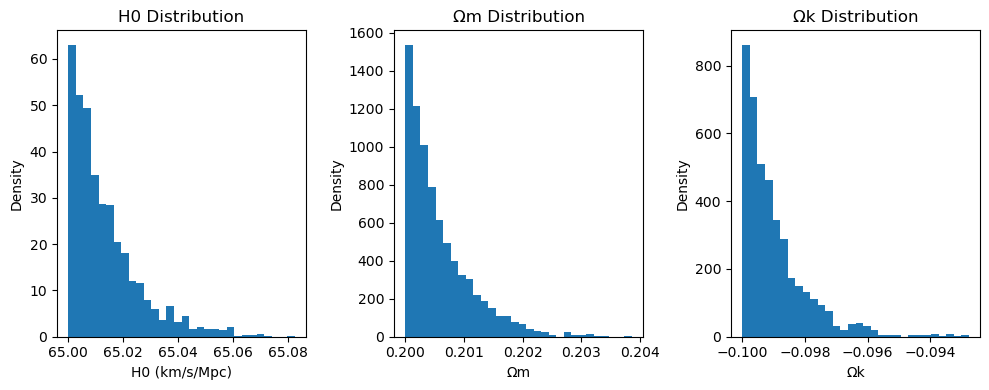

Infered Parameters:
H0: 65.01 ± 0.01
Ωm: 0.20 ± 0.00
Ωk: -0.10 ± 0.00
OL: 0.80 ± 0.00


In [47]:
import matplotlib.pyplot as plt
# Get samples
samples = mcmc.get_samples()

# Create figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

# Plot H0 histogram
ax1.hist(samples['H0'], bins=30, density=True)
ax1.set_xlabel('H0 (km/s/Mpc)')
ax1.set_ylabel('Density')
ax1.set_title('H0 Distribution')

# Plot Om histogram 
ax2.hist(samples['Om'], bins=30, density=True)
ax2.set_xlabel('Ωm')
ax2.set_ylabel('Density')
ax2.set_title('Ωm Distribution')

# Plot Ok histogram
ax3.hist(samples['Ok'], bins=30, density=True)
ax3.set_xlabel('Ωk')
ax3.set_ylabel('Density')
ax3.set_title('Ωk Distribution')

plt.tight_layout()
plt.show()

print("Infered Parameters:")
print("H0: {:.2f} ± {:.2f}".format(jnp.mean(samples['H0']), jnp.std(samples['H0'])))
print("Ωm: {:.2f} ± {:.2f}".format(jnp.mean(samples['Om']), jnp.std(samples['Om'])))
print("Ωk: {:.2f} ± {:.2f}".format(jnp.mean(samples['Ok']), jnp.std(samples['Ok'])))
print("OL: {:.2f} ± {:.2f}".format(1-jnp.mean(samples['Om']), jnp.std(samples['Om'])))